# QSimLite


QSimLite is a lightweight quantum statevector simulator developed in Python. It provides a simple framework for representing and manipulating quantum states using linear algebra operations. The simulator models qubits as complex-valued statevectors and supports the application of quantum gates (such as Hadamard, Pauli-X, and CNOT) through unitary matrix transformations.

This simulator was implemented as a project for the course Quantum Computing for Computer Scientists (DD2367). The goal of the project is to implement a statevector-based quantum simulator using only linear algebra operations, and to conduct experiments on the Quantum Fourier Transform (QFT) and its approximate version (AQFT).

In [20]:
# Basic funtions

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT as QiskitQFT
DTYPE = np.complex128
import math
import time

In [14]:

def ket(bitstring: str) -> np.ndarray:
    if not bitstring:
        raise ValueError("Bitstring cannot be empty.")
    if not all(c in '01' for c in bitstring):
        raise ValueError("Bitstring must only contain '0' or '1'.")
    num_qubits = len(bitstring)
    state_size = 2**num_qubits
    index = int(bitstring, 2)
    state_vector = np.zeros((state_size, 1), dtype=DTYPE)
    state_vector[index, 0] = 1.0
    return state_vector

def normalize(v: np.ndarray) -> np.ndarray:
    norm = np.linalg.norm(v)
    if np.isclose(norm, 0):
        raise ValueError("Zero vector cannot be normalized.")
    return v / norm

def ket_notation(state_vector: np.ndarray, tolerance: float = 1e-10) -> str:
    num_qubits = int(np.log2(state_vector.shape[0]))
    state = state_vector.flatten()
    ket_parts = []
    for i, amp in enumerate(state):
        if abs(amp) > tolerance:
            basis = format(i, f'0{num_qubits}b')
            amp_str = f"{amp.real:.3f}" if abs(amp.imag) < tolerance else f"({amp:.3f})"
            ket_parts.append(f"{amp_str}|{basis}⟩")
    if not ket_parts:
        return "0"
    return " + ".join(ket_parts).replace("+ -", "- ")

def apply_gate(state_vector: np.ndarray, gate_matrix: np.ndarray, target_qubit: int) -> np.ndarray:
    num_qubits = int(np.log2(state_vector.shape[0]))
    I_gate = np.identity(2, dtype=DTYPE)
    full_operator = np.array([[1.0]], dtype=DTYPE)
    for qubit_index in range(num_qubits - 1, -1, -1):
        if qubit_index == target_qubit:
            full_operator = np.kron(full_operator, gate_matrix)
        else:
            full_operator = np.kron(full_operator, I_gate)
    return np.dot(full_operator, state_vector)

def apply_x(state_vector: np.ndarray, target_qubit: int) -> np.ndarray:
    X_gate = np.array([[0, 1], [1, 0]], dtype=DTYPE)
    return apply_gate(state_vector, X_gate, target_qubit)

def apply_h(state_vector: np.ndarray, target_qubit: int) -> np.ndarray:
    H_gate = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]], dtype=DTYPE)
    return apply_gate(state_vector, H_gate, target_qubit)


def calculate_fidelity(state_ideal: np.ndarray, state_actual: np.ndarray) -> float:
    return np.abs(np.vdot(state_ideal, state_actual))**2


class QubitSystem:
    def __init__(self, statevector: np.ndarray, label: str = "Qubit System"):
        self.label = label
        self.set_statevector(statevector)

    def set_statevector(self, statevector: np.ndarray):
        sv = np.asarray(statevector, dtype=np.complex128).flatten()
        sv = sv / np.linalg.norm(sv)
        n_states = sv.size
        self.n_qubits = int(round(math.log2(n_states)))
        self.n_states = n_states
        self.amps  = sv
        self.prob  = np.abs(sv)**2
        self.phase = np.angle(sv)

    def viz_circle(self, max_cols: int = 8, figsize_scale: float = 2.3):
        cols = max(1, min(max_cols, self.n_states))
        rows = int(math.ceil(self.n_states / cols))
        fig, axes = plt.subplots(
            rows, cols,
            figsize=(cols*figsize_scale, rows*(figsize_scale+0.2))
        )
        axes = np.atleast_2d(axes)

        def bitstr(i: int, n: int) -> str:
            return format(i, f"0{n}b")

        for idx in range(rows * cols):
            r, c = divmod(idx, cols)
            ax = axes[r, c]
            ax.set_aspect("equal")
            ax.set_xlim(0, 1); ax.set_ylim(0, 1)
            ax.axis("off")
            if idx >= self.n_states:
                ax.set_visible(False)
                continue


            ax.add_patch(plt.Circle((0.5, 0.5), 0.48, fill=False, lw=1.0, alpha=0.5))
            radius = 0.48 * np.sqrt(self.prob[idx])
            ax.add_patch(plt.Circle((0.5, 0.5), radius, alpha=0.25))

            angle = self.phase[idx]
            L = 0.45
            x2 = 0.5 + L*np.cos(angle)
            y2 = 0.5 + L*np.sin(angle)
            ax.arrow(0.5, 0.5, x2-0.5, y2-0.5,
                     head_width=0.03, head_length=0.05, length_includes_head=True)
            ax.set_title(f"|{bitstr(idx, self.n_qubits)}⟩", fontsize=10)

        fig.suptitle(self.label, fontsize=12)
        plt.tight_layout()
        plt.show()
    
    def viz_distribution(self, figsize=(10, 4)):
        x_values = np.arange(self.n_states)
        
        plt.figure(figsize=figsize)
        plt.bar(x_values, self.prob, color='skyblue', width=0.8)
        
        # Add labels and title for clarity
        plt.title(self.label, fontsize=14)
        plt.xlabel("Computational Basis State Index", fontsize=12)
        plt.ylabel("Probability |α|²", fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        
        # Set plot limits and add a grid
        plt.xlim(-0.5, self.n_states - 0.5)
        plt.ylim(bottom=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        
        # Generate a filename from the label
        filename = f"dist_{self.label.lower().replace(' ', '_').split(':')[1].strip()}.png"
        plt.savefig(filename)
        print(f"Saved regular plot: {filename}")
        
        plt.show()

def get_swap_matrix(num_qubits: int, qubit_a: int, qubit_b: int) -> np.ndarray:
    size = 2**num_qubits
    swap_matrix = np.zeros((size, size), dtype=DTYPE)

    for i in range(size):
        bit_a = (i >> qubit_a) & 1
        bit_b = (i >> qubit_b) & 1

        if bit_a != bit_b:
            swap_mask = (1 << qubit_a) | (1 << qubit_b)
            output_index = i ^ swap_mask
        else:
            output_index = i

        swap_matrix[output_index, i] = 1
        
    return swap_matrix


def apply_swap(state_vector: np.ndarray, qubit_a: int, qubit_b: int) -> np.ndarray:

    num_qubits = int(np.log2(state_vector.shape[0]))
    swap_operator = get_swap_matrix(num_qubits, qubit_a, qubit_b)
    
    return np.dot(swap_operator, state_vector)

def get_toffoli_matrix(num_qubits: int, control_qubit1: int, control_qubit2: int, target_qubit: int) -> np.ndarray:
    size = 2**num_qubits
    toffoli_matrix = np.zeros((size, size), dtype=DTYPE)

    for i in range(size):
        is_control1_one = (i >> control_qubit1) & 1
        is_control2_one = (i >> control_qubit2) & 1

        if is_control1_one and is_control2_one:
            output_index = i ^ (1 << target_qubit)
        else:
            output_index = i

        toffoli_matrix[output_index, i] = 1
        
    return toffoli_matrix


def apply_toffoli(state_vector: np.ndarray, control_qubit1: int, control_qubit2: int, target_qubit: int) -> np.ndarray:
    num_qubits = int(np.log2(state_vector.shape[0]))
    toffoli_operator = get_toffoli_matrix(num_qubits, control_qubit1, control_qubit2, target_qubit)
    return np.dot(toffoli_operator, state_vector)

def get_cphase_matrix(num_qubits: int, control_qubit: int, target_qubit: int, angle_phi: float) -> np.ndarray:

    size = 2**num_qubits
    cphase_matrix = np.identity(size, dtype=DTYPE)

    phase = np.exp(1j * angle_phi)

    for i in range(size):
        is_both_one = ((i >> control_qubit) & 1) and ((i >> target_qubit) & 1)
        if is_both_one:
            cphase_matrix[i, i] = phase
            
    return cphase_matrix


def apply_cphase(state_vector: np.ndarray, control_qubit: int, target_qubit: int, angle_phi: float) -> np.ndarray:
    num_qubits = int(np.log2(state_vector.shape[0]))
    cphase_operator = get_cphase_matrix(num_qubits, control_qubit, target_qubit, angle_phi)
    return np.dot(cphase_operator, state_vector)

import numpy as np

def get_cnot_matrix(num_qubits: int, control_qubit: int, target_qubit: int) -> np.ndarray:
    size = 2**num_qubits
    cnot_matrix = np.zeros((size, size), dtype=DTYPE)

    for i in range(size):
        is_control_one = (i >> control_qubit) & 1

        if is_control_one:
            output_index = i ^ (1 << target_qubit)
        else:
            output_index = i

        cnot_matrix[output_index, i] = 1
        
    return cnot_matrix


def apply_cnot(state_vector: np.ndarray, control_qubit: int, target_qubit: int) -> np.ndarray:

    num_qubits = int(np.log2(state_vector.shape[0]))
    

    cnot_operator = get_cnot_matrix(num_qubits, control_qubit, target_qubit)
    return np.dot(cnot_operator, state_vector)

def apply_qft(state_vector: np.ndarray) -> np.ndarray:
    num_qubits = int(np.log2(state_vector.shape[0]))
    new_state = state_vector.copy()

    for j in reversed(range(num_qubits)):
        new_state = apply_h(new_state, j)

        for k in reversed(range(j)):
            angle = np.pi / (2**(j - k))
            new_state = apply_cphase(new_state, control_qubit=k, target_qubit=j, angle_phi=angle)
            
    for j in range(num_qubits // 2):
        new_state = apply_swap(new_state, j, num_qubits - 1 - j)

    return new_state

def apply_approx_qft(state_vector: np.ndarray, truncation_level: int):
    num_qubits = int(np.log2(state_vector.shape[0]))
    new_state = state_vector.copy()
    
    gate_counts = {'H': 0, 'CPHASE': 0}

    for j in reversed(range(num_qubits)):
        new_state = apply_h(new_state, j)
        gate_counts['H'] += 1
        for k in reversed(range(j)):

            if truncation_level > 0 and (j - k) > truncation_level:
                continue

            angle = np.pi / (2**(j - k))
            new_state = apply_cphase(new_state, control_qubit=k, target_qubit=j, angle_phi=angle)
            gate_counts['CPHASE'] += 1
            
    for j in range(num_qubits // 2):
        new_state = apply_swap(new_state, j, num_qubits - 1 - j)

    return new_state, gate_counts

#Code for circle notation given at the course DD2367 Quantum Computing for Computer Scientists at KTH
class QubitSystem:
    def __init__(self, statevector: np.ndarray, label: str = "Qubit System"):
        self.label = label
        self.set_statevector(statevector)

    def set_statevector(self, statevector: np.ndarray):
        sv = np.asarray(statevector, dtype=np.complex128).flatten()
        sv = sv / np.linalg.norm(sv)
        n_states = sv.size
        self.n_qubits = int(round(math.log2(n_states)))
        self.n_states = n_states
        self.amps  = sv
        self.prob  = np.abs(sv)**2
        self.phase = np.angle(sv)

    def viz_circle(self, max_cols: int = 8, figsize_scale: float = 2.3):
        cols = max(1, min(max_cols, self.n_states))
        rows = int(math.ceil(self.n_states / cols))
        fig, axes = plt.subplots(
            rows, cols,
            figsize=(cols*figsize_scale, rows*(figsize_scale+0.2))
        )
        axes = np.atleast_2d(axes)

        def bitstr(i: int, n: int) -> str:
            return format(i, f"0{n}b")

        for idx in range(rows * cols):
            r, c = divmod(idx, cols)
            ax = axes[r, c]
            ax.set_aspect("equal")
            ax.set_xlim(0, 1); ax.set_ylim(0, 1)
            ax.axis("off")
            if idx >= self.n_states:
                ax.set_visible(False)
                continue


            ax.add_patch(plt.Circle((0.5, 0.5), 0.48, fill=False, lw=1.0, alpha=0.5))
            radius = 0.48 * np.sqrt(self.prob[idx])
            ax.add_patch(plt.Circle((0.5, 0.5), radius, alpha=0.25))

            angle = self.phase[idx]
            L = 0.45
            x2 = 0.5 + L*np.cos(angle)
            y2 = 0.5 + L*np.sin(angle)
            ax.arrow(0.5, 0.5, x2-0.5, y2-0.5,
                     head_width=0.03, head_length=0.05, length_includes_head=True)
            ax.set_title(f"|{bitstr(idx, self.n_qubits)}⟩", fontsize=10)

        fig.suptitle(self.label, fontsize=12)
        plt.tight_layout()
        plt.show()
    
    def viz_distribution(self, figsize=(10, 4)):
        x_values = np.arange(self.n_states)
        
        plt.figure(figsize=figsize)
        plt.bar(x_values, self.prob, color='skyblue', width=0.8)
        
        # Add labels and title for clarity
        plt.title(self.label, fontsize=14)
        plt.xlabel("Computational Basis State Index", fontsize=12)
        plt.ylabel("Probability |α|²", fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        
        # Set plot limits and add a grid
        plt.xlim(-0.5, self.n_states - 0.5)
        plt.ylim(bottom=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        
        # Generate a filename from the label
        filename = f"dist_{self.label.lower().replace(' ', '_').split(':')[1].strip()}.png"
        plt.savefig(filename)
        print(f"Saved regular plot: {filename}")
        
        plt.show()

In [15]:
# Test Functions
PASS_COLOR = '\033[92m'
FAIL_COLOR = '\033[91m'
RESET_COLOR = '\033[0m'

def create_superposition_state(n_qubits):
    qc_initial = QuantumCircuit(n_qubits)
    qc_initial.h(range(n_qubits))
    qiskit_sv = Statevector(qc_initial)
    sim_sv = qiskit_sv.data.reshape(-1, 1)
    return qiskit_sv, sim_sv

def run_test(test_name, sim_final_state, qiskit_final_state):
    sim_flat = sim_final_state.flatten()
    qiskit_flat = qiskit_final_state.data
    is_match = np.allclose(sim_flat, qiskit_flat, atol=TOLERANCE)
    status = f"{PASS_COLOR}PASS{RESET_COLOR}" if is_match else f"{FAIL_COLOR}FAIL{RESET_COLOR}"
    print(f"Testing {test_name:<25} ... {status}")
    if not is_match:
        print(f"  - Simulator Output: {ket_notation(sim_final_state)}")
        print(f"  - Qiskit Output:    {ket_notation(qiskit_final_state.data.reshape(-1, 1))}")

## Comparison with Qiskit

The following section evaluates the correctness of the implemented gates and functions by comparing their results with those obtained using the Qiskit framework.

In [16]:
# Test script
NUM_QUBITS = 9
TOLERANCE = 1e-10

bitstring = '111010101'
n_ket = len(bitstring)
index = int(bitstring, 2)
sim_state_ket = ket(bitstring)
qiskit_state_ket = Statevector.from_int(index, dims=2**n_ket)
run_test(f"ket('{bitstring}')", sim_state_ket, qiskit_state_ket)

print("-" * 40)

qiskit_sv_initial, sim_sv_initial = create_superposition_state(NUM_QUBITS)

target_qubit_h = 1
qc_h = QuantumCircuit(NUM_QUBITS)
qc_h.h(target_qubit_h)
qiskit_final_h = qiskit_sv_initial.evolve(qc_h)
sim_final_h = apply_h(sim_sv_initial, target_qubit_h)
run_test("apply_h", sim_final_h, qiskit_final_h)

control_cnot, target_cnot = 0, 2
qc_cnot = QuantumCircuit(NUM_QUBITS)
qc_cnot.cx(control_cnot, target_cnot)
qiskit_final_cnot = qiskit_sv_initial.evolve(qc_cnot)
sim_final_cnot = apply_cnot(sim_sv_initial, control_cnot, target_cnot)
run_test("apply_cnot", sim_final_cnot, qiskit_final_cnot)

control_cp, target_cp = 1, 3
angle_cp = np.pi / 4
qc_cp = QuantumCircuit(NUM_QUBITS)
qc_cp.cp(angle_cp, control_cp, target_cp)
qiskit_final_cp = qiskit_sv_initial.evolve(qc_cp)
sim_final_cp = apply_cphase(sim_sv_initial, control_cp, target_cp, angle_cp)
run_test("apply_cphase", sim_final_cp, qiskit_final_cp)

qubit_a, qubit_b = 0, 3
qc_swap = QuantumCircuit(NUM_QUBITS)
qc_swap.swap(qubit_a, qubit_b)
qiskit_final_swap = qiskit_sv_initial.evolve(qc_swap)
sim_final_swap = apply_swap(sim_sv_initial, qubit_a, qubit_b)
run_test("apply_swap", sim_final_swap, qiskit_final_swap)

c1_toffoli, c2_toffoli, t_toffoli = 0, 1, 3
qc_toffoli = QuantumCircuit(NUM_QUBITS)
qc_toffoli.ccx(c1_toffoli, c2_toffoli, t_toffoli)
qiskit_final_toffoli = qiskit_sv_initial.evolve(qc_toffoli)
sim_final_toffoli = apply_toffoli(sim_sv_initial, c1_toffoli, c2_toffoli, t_toffoli)
run_test("apply_toffoli", sim_final_toffoli, qiskit_final_toffoli)

print("-" * 40)

qft_gate = QiskitQFT(num_qubits=NUM_QUBITS, do_swaps=True)
qc_qft = QuantumCircuit(NUM_QUBITS)
qc_qft.append(qft_gate, range(NUM_QUBITS))
qiskit_final_qft = qiskit_sv_initial.evolve(qc_qft)
qc_qft.draw(output='mpl', filename='qft_4_qubits.png')
sim_final_qft = apply_qft(sim_sv_initial)
run_test("apply_qft (full)", sim_final_qft, qiskit_final_qft)


print("\n--- Validation Complete ---")

Testing ket('111010101')          ... PASS
----------------------------------------
Testing apply_h                   ... PASS
Testing apply_cnot                ... PASS
Testing apply_cphase              ... PASS
Testing apply_swap                ... PASS
Testing apply_toffoli             ... PASS
----------------------------------------


/tmp/ipykernel_43592/439852270.py:54: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_gate = QiskitQFT(num_qubits=NUM_QUBITS, do_swaps=True)


Testing apply_qft (full)          ... PASS

--- Validation Complete ---


# Experiments

In this section, we implement and test the Quantum Fourier Transform (QFT) and its approximate version (AQFT). To evaluate their performance, we conduct a series of experiments measuring the runtime as a function of the number of qubits (n) and the fidelity of the approximate QFT relative to different truncation levels.

In [17]:
#Functions to prepare 3 different inputs for the QFT
# Add these three functions to your simulator.py file

def prepare_spike_state(n_qubits: int, position: int):
    if position >= 2**n_qubits:
        raise ValueError("Position is out of range for the number of qubits.")
    bitstring = format(position, f'0{n_qubits}b')
    return ket(bitstring)

def prepare_square_wave_state(n_qubits: int, width: int):
    N = 2**n_qubits
    if width > N:
        raise ValueError("Width cannot be larger than the total number of states.")
    
    state_vector = np.zeros((N, 1), dtype=DTYPE)
    start_index = (N - width) // 2
    end_index = start_index + width
    
    state_vector[start_index:end_index, 0] = 1.0
    return normalize(state_vector)

def prepare_gaussian_state(n_qubits: int, sigma_width_factor: float = 8.0):
    N = 2**n_qubits
    mu = (N - 1) / 2  # Center of the distribution
    x_values = np.arange(N)
    
    sigma = N / sigma_width_factor
    
    amplitudes = np.exp(-(x_values - mu)**2 / (2 * sigma**2))
    state_vector = amplitudes.reshape(-1, 1)
    
    return normalize(state_vector)

def prepare_alternating_state(n_qubits: int):
    N = 2**n_qubits
    state_vector = np.zeros((N, 1), dtype=DTYPE)
    

    even_indices = np.arange(0, N, 2)
    state_vector[even_indices, 0] = 1.0
    
    return normalize(state_vector)

--- Preparing and Visualizing 4-qubit Input Signals ---


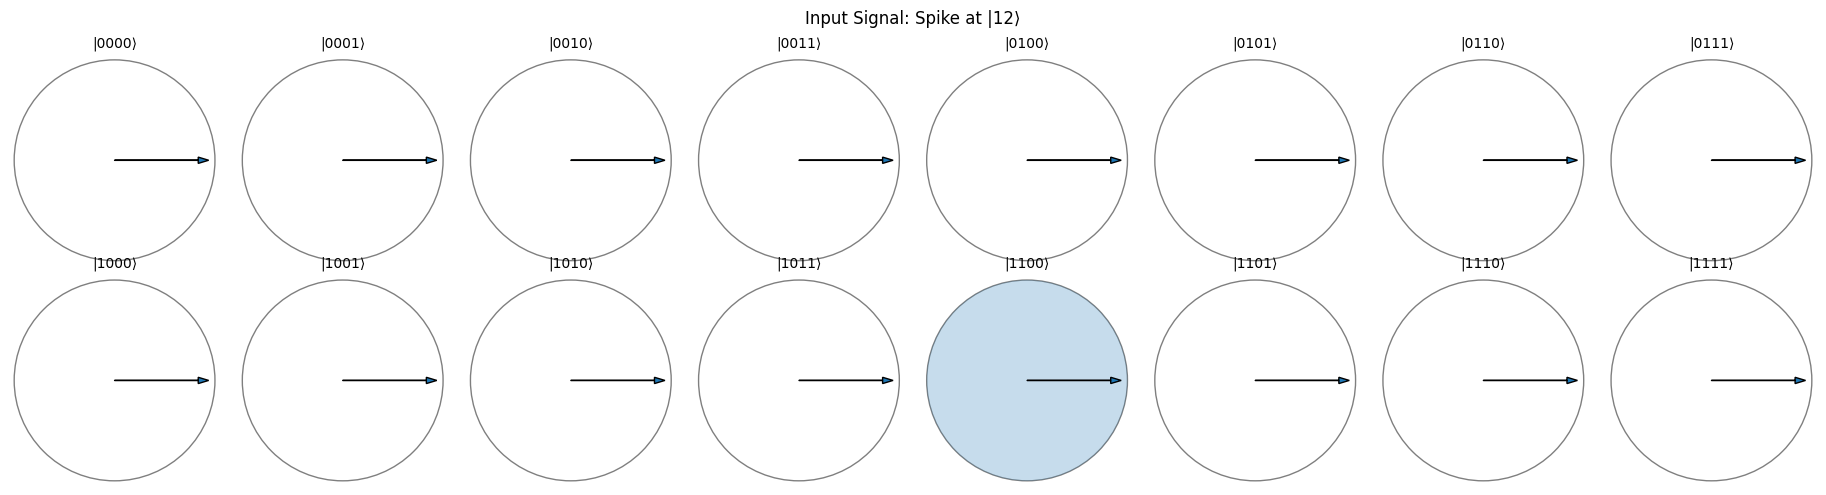

Saved regular plot: dist__spike_at_|12⟩.png


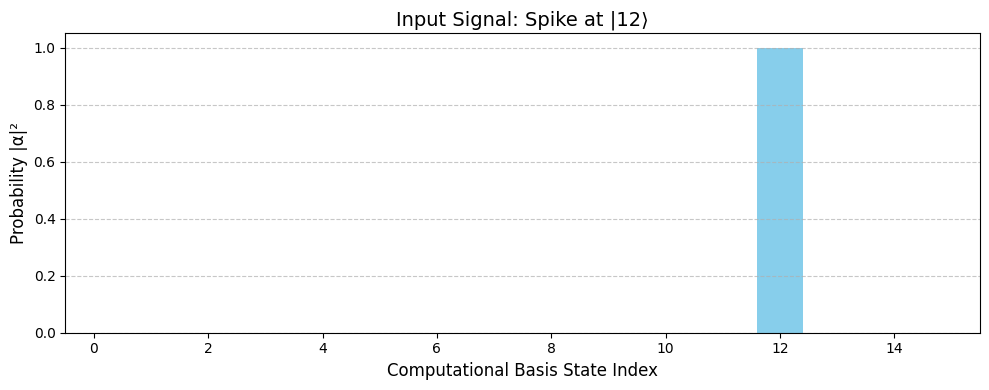

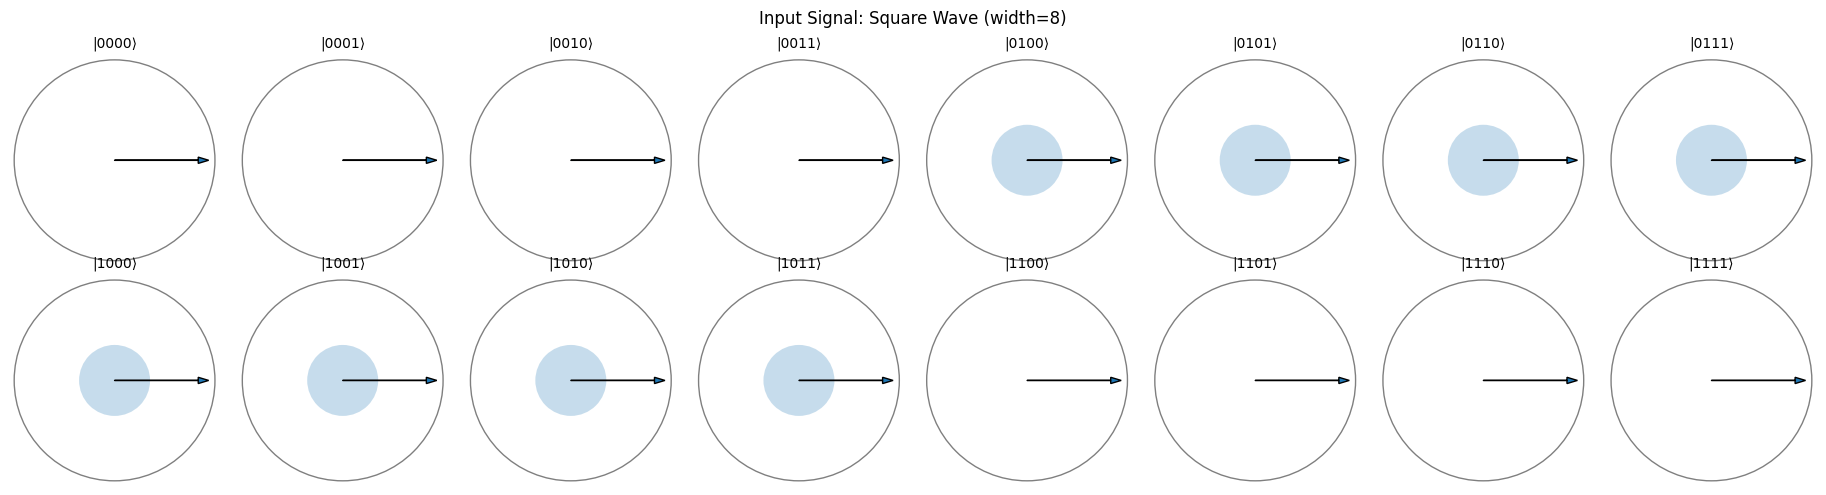

Saved regular plot: dist__square_wave_(width=8).png


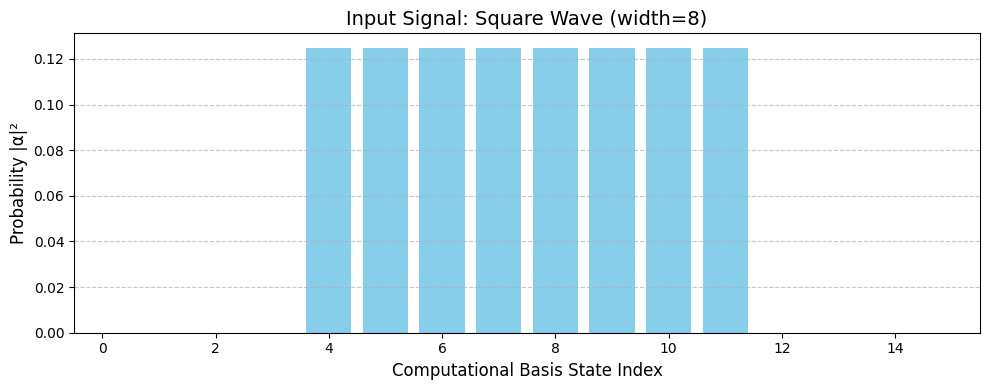

In [18]:
#Example
N_QUBITS_VIZ = 4  # (32 states is good for a plot)

print(f"--- Preparing and Visualizing {N_QUBITS_VIZ}-qubit Input Signals ---")

spike_position = 12
spike_input = prepare_spike_state(N_QUBITS_VIZ, position=spike_position)
viz_spike = QubitSystem(spike_input, label=f"Input Signal: Spike at |{spike_position}⟩")
viz_spike.viz_circle()
viz_spike.viz_distribution()

square_width = 8
square_input = prepare_square_wave_state(N_QUBITS_VIZ, width=square_width)
viz_square = QubitSystem(square_input, label=f"Input Signal: Square Wave (width={square_width})")
viz_square.viz_circle()
viz_square.viz_distribution()

--- Starting Experiment 1: QFT Simulation Runtime vs. Number of Qubits ---
  n =  2 qubits | Avg time over 50 runs: 0.002170 seconds
  n =  3 qubits | Avg time over 50 runs: 0.001393 seconds
  n =  4 qubits | Avg time over 50 runs: 0.002321 seconds
  n =  5 qubits | Avg time over 50 runs: 0.002941 seconds
  n =  6 qubits | Avg time over 50 runs: 0.028693 seconds
  n =  7 qubits | Avg time over 50 runs: 0.078862 seconds
  n =  8 qubits | Avg time over 50 runs: 0.350679 seconds
  n =  9 qubits | Avg time over 50 runs: 0.554107 seconds

Saved timing experiment plot: qft_timing_experiment.png


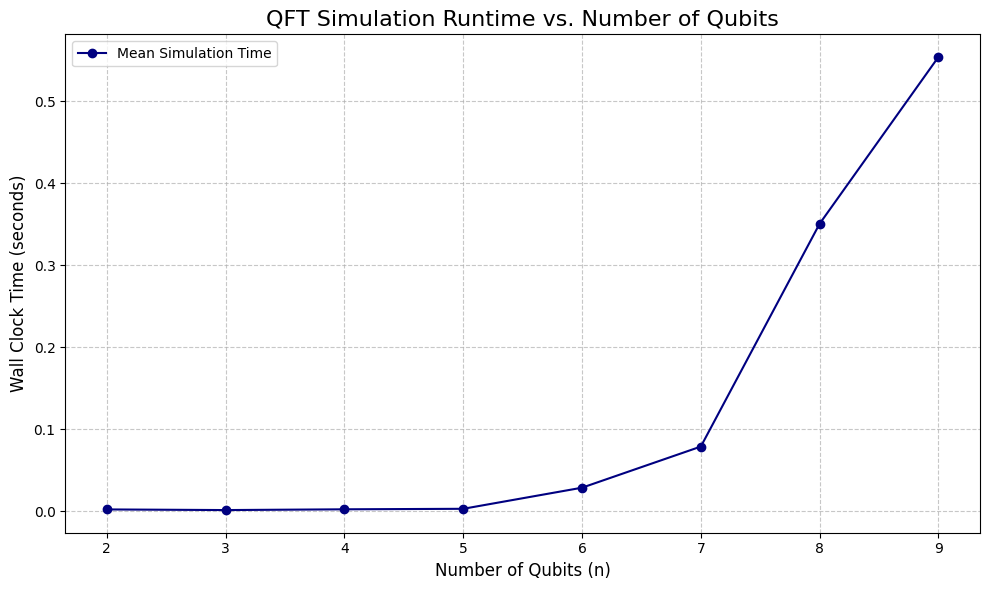

In [21]:
#Runtime Experiment

def run_qft_timing_experiment(qubit_range, num_runs_per_n):
    print("--- Starting Experiment 1: QFT Simulation Runtime vs. Number of Qubits ---")
    
    mean_times = []

    for n in qubit_range:
        current_n_times = []
        initial_state = prepare_alternating_state(n)

        for i in range(num_runs_per_n):
            start_time = time.perf_counter()
            apply_approx_qft(initial_state, truncation_level=0)
            end_time = time.perf_counter()
            current_n_times.append(end_time - start_time)

        mean_duration = np.mean(current_n_times)
        mean_times.append(mean_duration)
        
        print(f"  n = {n:2d} qubits | Avg time over {num_runs_per_n} runs: {mean_duration:.6f} seconds")

    fig, ax = plt.subplots(figsize=(10, 6))   
    ax.plot(list(qubit_range), mean_times, 'o-', color='navy', label='Mean Simulation Time')
    ax.set_title("QFT Simulation Runtime vs. Number of Qubits", fontsize=16)
    ax.set_xlabel("Number of Qubits (n)", fontsize=12)
    ax.set_ylabel("Wall Clock Time (seconds)", fontsize=12)
    #ax.set_yscale('log')
    ax.grid(True, which="both", ls="--", alpha=0.7)
    ax.legend()
    
    plt.tight_layout()
    plt.savefig("qft_timing_experiment.png")
    print("\nSaved timing experiment plot: qft_timing_experiment.png")
    plt.show()

TIMING_QUBIT_RANGE = range(2, 10)
NUM_RUNS_PER_N = 50
run_qft_timing_experiment(TIMING_QUBIT_RANGE, NUM_RUNS_PER_N)


--- Starting Experiment: Truncation Error vs. System Size (n) ---
  Analyzing truncation for n = 4 qubits...
  Analyzing truncation for n = 5 qubits...
  Analyzing truncation for n = 6 qubits...
  Analyzing truncation for n = 7 qubits...
  Analyzing truncation for n = 8 qubits...
  Analyzing truncation for n = 9 qubits...
Saved: fidelity_square_wave.png


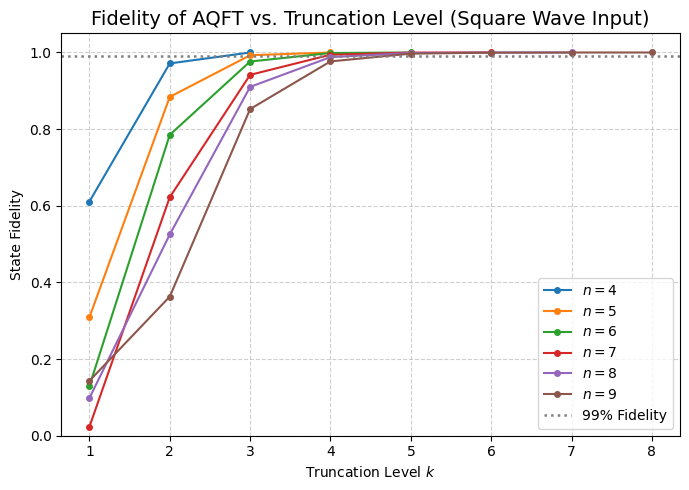

Saved: fidelity_gaussian.png


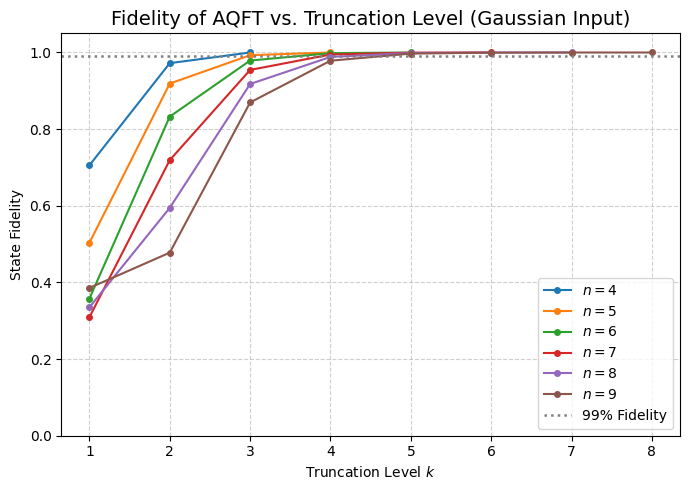


All fidelity plots generated successfully.


In [22]:
# Approximate QFT Truncation Experiment

def run_multin_truncation_experiment(qubit_range, signals_to_test):
    print("\n--- Starting Experiment: Truncation Error vs. System Size (n) ---")

    all_results = {name: {} for name in signals_to_test.keys()}
    states_for_plotting = {}
    
    n_for_viz = max(qubit_range)
    level_for_viz = n_for_viz // 2

    for n in qubit_range:
        print(f"  Analyzing truncation for n = {n} qubits...")

        initial_states = {}
        for signal_name, func in signals_to_test.items():
            if signal_name == "Spike":
                initial_states[signal_name] = func(n, position=n // 3)
            elif signal_name == "Square Wave":
                initial_states[signal_name] = func(n, width=n // 2)
            elif signal_name == "Gaussian":
                initial_states[signal_name] = func(n, sigma_width_factor=8.0)
            elif signal_name == "Alternating":
                initial_states[signal_name] = func(n)
            else:
                raise ValueError(f"Unknown signal type '{signal_name}'")

        for name, initial_state in initial_states.items():
            ideal_state = apply_qft(initial_state)
            fidelities = []
            truncation_levels = list(range(1, n))

            for level in truncation_levels:
                approx_state, _ = apply_approx_qft(initial_state, level)
                fidelity_val = calculate_fidelity(ideal_state, approx_state)
                fidelities.append(fidelity_val)

                if n == n_for_viz and level == level_for_viz:
                    states_for_plotting[name] = (ideal_state, approx_state)

            all_results[name][n] = (truncation_levels, fidelities)

    for name, results in all_results.items():
        plt.figure(figsize=(7, 5))
        for n in qubit_range:
            x_data, y_data = results[n]
            if x_data:
                plt.plot(x_data, y_data, 'o-', label=f'$n={n}$', markersize=4)

        plt.title(f"Fidelity of AQFT vs. Truncation Level ({name} Input)", fontsize=14)
        plt.xlabel("Truncation Level $k$")
        plt.ylabel("State Fidelity")
        plt.axhline(y=0.99, color='gray', linestyle=':', linewidth=1.8, label='99% Fidelity')
        plt.grid(True, which="both", ls="--", alpha=0.6)
        plt.legend()
        plt.ylim(0, 1.05)
        plt.tight_layout()

        filename = f"fidelity_{name.replace(' ', '_').lower()}.png"
        plt.savefig(filename)
        print(f"Saved: {filename}")
        plt.show()

    print("\nAll fidelity plots generated successfully.")

TRUNCATION_QUBIT_RANGE = range(4, 10)

SIGNALS_TO_TEST = {
    #"Spike": prepare_spike_state,
    "Square Wave": prepare_square_wave_state,
    "Gaussian": prepare_gaussian_state,
    #"Alternating": prepare_alternating_state
}

run_multin_truncation_experiment(TRUNCATION_QUBIT_RANGE, SIGNALS_TO_TEST)